### Settings & imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap, LogNorm, PowerNorm, AsinhNorm
from matplotlib.ticker import MaxNLocator, LogLocator

import numpy as np

import pulp

import pickle

import seaborn as sns

from textwrap import wrap

from pathlib import Path

import pandas as pd

In [4]:
nr_of_experiment = 10

In [5]:
if nr_of_experiment == 10:
    variant = 0

### Experiments data

In [6]:
components_dictionary = {'experiment_1': ['Pinene', 'Benzyl benzoate'],
                        'experiment_2': ['Pinene', 'Limonene'],
                        'experiment_7': ['Benzyl benzoate', 'm Anisaldehyde'],
                        'experiment_3': ['Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'],
                        'experiment_6': ['Pinene', 'Benzyl benzoate'],
                        'experiment_5': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_9': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_4': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_8': ['Benzyl benzoate', 'm Anisaldehyde'],
                         'experiment_10': ['Leucine', 'Isoleucine', 'Valine'],
                        'experiment_11': ['Leucine', 'Isoleucine', 'Valine']}

In [7]:
protons_dictionary = {'experiment_1': [16, 12],
                        'experiment_2': [16, 16],
                        'experiment_7': [12, 8],
                        'experiment_3': [34, 12, 16, 16],
                        'experiment_6': [16, 12],
                        'experiment_5': [4, 4, 5, 5, 13],
                        'experiment_9': [4, 4, 5, 5, 13],
                        'experiment_4': [4, 4, 5, 5, 13],
                        'experiment_8': [12, 8],
                        'experiment_10': [10, 10, 8],
                        'experiment_11': [10, 10, 8]}

In [8]:
exp_10_molar_proportions = [
                            [0.3401, 0.3299, 0.3299],
                            [0.2525, 0.2475, 0.5],
                            [0.2538, 0.4949, 0.2513],
                            [0.2075, 0.3942, 0.3983]
                            ]

In [9]:
if nr_of_experiment == 10:
    ground_truth_molar_proportions = {'experiment_1': [0.09088457406472417, 0.9091154259352758],
                                        'experiment_2': [0.505, 0.495],
                                        'experiment_7': [0.8403875207510383, 0.1596124792489616],
                                        'experiment_3': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                        'experiment_6': [0.3865, 0.6135],
                                        'experiment_5': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_9': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_4': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_8': [0.3702, 0.6298],
                                        'experiment_10': exp_10_molar_proportions[variant],
                                        'experiment_11': [0.4855, 0.2427, 0.2718]}
else:
    ground_truth_molar_proportions = {'experiment_1': [0.09088457406472417, 0.9091154259352758],
                                        'experiment_2': [0.505, 0.495],
                                        'experiment_7': [0.8403875207510383, 0.1596124792489616],
                                        'experiment_3': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                        'experiment_6': [0.3865, 0.6135],
                                        'experiment_5': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_9': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_4': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_8': [0.3702, 0.6298],
                                        'experiment_10': [],
                                        'experiment_11': [0.4855, 0.2427, 0.2718]}

In [10]:
cwd = Path(os.getcwd())
path = cwd.parent.absolute()

In [11]:
experiments_folders = [name for name in os.listdir(path)
                    if os.path.isdir(os.path.join(path, name)) and str(name).startswith('experiment')]

### Improving heatmaps

In [12]:
experiments_folders

['experiment_1_intensity_difference',
 'experiment_11_real_food_product',
 'experiment_8_different_solvents',
 'experiment_9_and_4_shim',
 'experiment_3_perfumes_and_absent_components',
 'experiment_10_bcaa',
 'experiment_5_metabolites',
 'experiment_2_overlapping',
 'experiment_7_overlapping_and_intensity_difference',
 'experiment_6_miniperfumes']

In [13]:
experiments_folders = {'experiment_1': 'experiment_1_intensity_difference',
                        'experiment_6': 'experiment_6_miniperfumes',
                        'experiment_5': 'experiment_5_metabolites',
                         'experiment_7': 'experiment_7_overlapping_and_intensity_difference',
                         'experiment_9': 'experiment_9_and_4_shim',
                       'experiment_4': 'experiment_9_and_4_shim',
                        'experiment_8': 'experiment_8_different_solvents',
                        'experiment_3': 'experiment_3_perfumes_and_absent_components',
                         'experiment_2': 'experiment_2_overlapping',
                       'experiment_10': 'experiment_10_bcaa',
                        'experiment_11': 'experiment_11_real_food_product'}

In [14]:
if (nr_of_experiment != 9 and nr_of_experiment != 4 and nr_of_experiment != 10):
    with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas.pkl', 'rb') as f:
        list_of_dataframes_with_results = pickle.load(f)
elif nr_of_experiment == 10:
    with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas_variant_'+str(variant+1)+'.pkl', 'rb') as f:
        list_of_dataframes_with_results = pickle.load(f)
else:
    with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas_exp'+str(nr_of_experiment)+'.pkl', 'rb') as f:
        list_of_dataframes_with_results = pickle.load(f)

In [15]:
molar_proportions = ground_truth_molar_proportions['experiment_'+str(nr_of_experiment)]
protons = protons_dictionary['experiment_'+str(nr_of_experiment)]

In [16]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [17]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [18]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

In [19]:
if (nr_of_experiment != 9 and nr_of_experiment != 4 and nr_of_experiment != 10):
    with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas.pkl', 'rb') as f:
        list_of_dataframes_with_results = pickle.load(f)
elif nr_of_experiment == 10:
    with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas_variant_'+str(variant+1)+'.pkl', 'rb') as f:
        list_of_dataframes_with_results = pickle.load(f)
else:
    with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas_exp'+str(nr_of_experiment)+'.pkl', 'rb') as f:
        list_of_dataframes_with_results = pickle.load(f)

In [20]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]

In [21]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [22]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

In [23]:
#all_components_results_both = (all_components_results_vis + all_components_results_molar)/2
#DELIBERATELY CHANGING TO TAKE INTO ACCOUNT ONLY ,,MOLAR'' ERROR IN HEATMAPS
all_components_results_both = all_components_results_molar

In [24]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [25]:
all_components_results_both.min().min()

0.0010862904795961303

In [26]:
all_components_results_both.shape

(30, 30)

In [27]:
if nr_of_experiment==3 or nr_of_experiment==8:
    all_components_results_both = all_components_results_both.iloc[:30,:30]

<IPython.core.display.Javascript object>


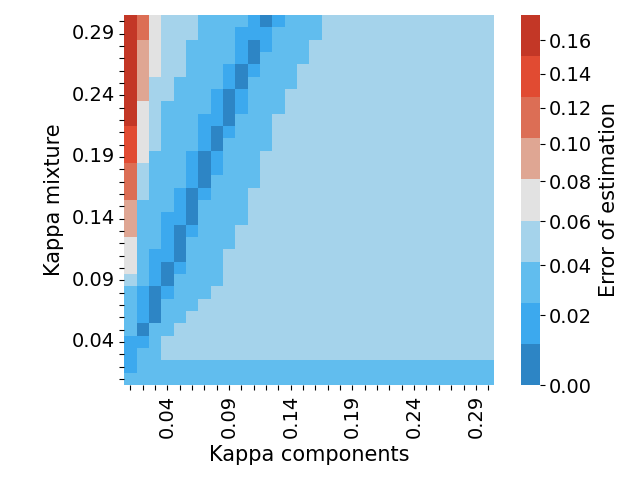

In [28]:
colors = ['#2D85C5', '#3CA9EE', '#61BDEE', '#A5D3EB',\
          '#E2E2E2', '#DFA693', '#DC6E55', '#E14B32', '#C33726']

#version with mean of molar and visible proportions
#powers_in_power_norm = [0.33, 0.8, 0.75, 0.55, 0.39, 0.28, 0.58, 0.342, 0.65]

#version with only molar proportions
powers_in_power_norm = [0.45, 1.5, 1.3, 0.65, 0.6, 0.5, 0.525, 0.455, 0.65, 0.75, 0.75]

remove_edge = False

vmin = all_components_results_both.min().min()
vmax = all_components_results_both.max().max()

my_cmap = ListedColormap(colors)
my_norm = PowerNorm(powers_in_power_norm[nr_of_experiment-1], vmin, vmax)

if remove_edge:
    all_components_results_both = all_components_results_both.iloc[1:, 1:]


labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]
if nr_of_experiment==3 or nr_of_experiment==8:
    labels = labels[:30]
if remove_edge:
    labels = labels[1:]
    

ax = sns.heatmap(all_components_results_both.astype(float), yticklabels=labels, cbar=True,
                square=True, vmin=vmin, vmax=vmax, xticklabels = labels,
                cmap=my_cmap, norm=my_norm, cbar_ax=None)

ax.invert_yaxis()

for ind, label in enumerate(ax.get_xticklabels()):
    if (ind + 2) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
for ind, label in enumerate(ax.get_yticklabels()):
    if (ind + 2) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

cbar = ax.collections[0].colorbar
cbar.set_label('Error of estimation', fontsize=15, labelpad=5)
cbar.ax.tick_params(labelsize=14)
# minorticks = [0.1, 0.2]
# cbar.ax.yaxis.set_ticks(minorticks, minor=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Kappa components", fontsize=15, labelpad=5)
plt.ylabel("Kappa mixture", fontsize=15, labelpad=5)

plt.tight_layout()
plt.show()

if nr_of_experiment != 10:
    plt.savefig('heatmap_experiment_'+str(nr_of_experiment)+'.png', dpi=300)
else:
    plt.savefig('heatmap_experiment_'+str(nr_of_experiment)+'_variant_'+str(variant+1)+'.png', dpi=300)